## Imports

In [1]:
import gc
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("deep")
from pycaret.regression import *
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression as Reg
from scipy.stats import pearsonr
import matplotlib as mpl
import statsmodels.api as sm

import shap
shap.initjs()

In [2]:
def cal_r2(x, y):
    x = np.array(x)
    y = np.array(y)
    my_fitting = np.polyfit(x, y, 1, full=True)
    SSE = my_fitting[1][0]
    diff = y - y.mean()
    square_diff = diff ** 2
    SST = square_diff.sum()
    R2 = 1 - SSE/SST
    return R2

def cal_rmse(x, y):
    sum = 0
    for i, j in zip(x, y):
        sum += (i - j) * (i - j)
    return np.sqrt(sum/len(x))

def cal_mae(x, y):
    sum = 0
    for i, j in zip(x, y):
        sum += abs(i - j)
    return sum / len(x)

def cal_mape(x, y, ref=0):
    if ref not in [0, 1]:
        raise Exception(f"InputError: ref must be one of [0, 1] but {ref} is given.")
    sum = 0
    for i, j in zip(x, y):
        if ref == 0:
            sum += abs((i - j) / i)
        elif ref == 1:
            sum += abs((i - j) / j)
    return sum / len(x)

## Data

In [3]:
def read_sample_data(file, tag=None):
    data = pd.read_csv(file, delimiter='\s+')

    # transform resident time to log scale
    data['rt'] = data['rt'].apply(lambda x: np.log10(x))

    # transform all data to numeric
    for col in data.columns:
        if col != 'lig':
            data[col] = pd.to_numeric(data[col].astype(float))
    
    lig_names = {'Lig': [f'{name}_{tag}' for name in data['lig'].tolist()]}
    data = data.join(pd.DataFrame(lig_names))
    data = data.drop(columns=['lig'])
    
    return data


In [4]:
def read_group_data(file, tag=None, keep_lig_col=True):
    data = pd.read_csv(file, delimiter='\s+')

    # transform resident time to log scale
    data['rt'] = data['rt'].apply(lambda x: np.log10(x))

    # transform all data to numeric
    for col in data.columns:
        if col != 'lig':
            data[col] = pd.to_numeric(data[col].astype(float))

    # drop features that are too small
    drop_cols = []
    for col in data.columns:
        if col != 'lig':
            if max(abs(data[col])) < 0.5:
                drop_cols.append(col)
    data = data.drop(columns=drop_cols)

    # features in traning
    feature_cols = [i for i in data.columns if i not in ['lig', 'rt']]
    if tag is not None:
        feature_cols = {key:f"{key}_{tag}" for key in feature_cols}
        data = data.rename(columns=feature_cols)
    if not keep_lig_col:
        feature_cols = [i for i in data.columns if i not in ['lig', 'rt']]
        return data[feature_cols]
    return data

In [5]:
def read_data(file, sample=None, group=None):
    data = pd.read_csv(file, delimiter='\s+')

    # transform resident time to log scale
    data['rt'] = data['rt'].apply(lambda x: np.log10(x))

    # transform all data to numeric
    for col in data.columns:
        if col != 'lig':
            data[col] = pd.to_numeric(data[col].astype(float))

    # rename column names by group names
    feature_cols = [i for i in data.columns if i not in ['lig', 'rt']]
    if group is not None:
        feature_cols = {key:f"{key}-{group}" for key in feature_cols}
        data = data.rename(columns=feature_cols)

    # rename 'lig' names by sample names
    if sample is not None:
        lig_names = {'Lig': [f'{name}_{sample}' for name in data['lig'].tolist()]}
        data = data.join(pd.DataFrame(lig_names))
        data = data.drop(columns=['lig'])
    return data

In [6]:
from itertools import product
samples = np.arange(1,100)
r1_data = read_data('snapshot_groups/total_r1_run0.dat', sample='0',group=None)
for s in samples:
    r1_data = r1_data.append(read_data(f'snapshot_groups/total_r1_run{s}.dat', sample=s,group=None))

    
data = r1_data
gc.collect()

709

In [7]:
data = data.reset_index()
data = data.drop(['index'],axis=1)
data

,D147-R1,M151-R1,S154-R1,I155-R1,V236-R1,A240-R1,W293-R1,H297-R1,W318-R1,I322-R1,Y326-R1,D147-R2,Y148-R2,K233-R2,V236-R2,V300-R2,W318-R2,D147-R4,Y148-R4,H297-R4,V300-R4,K233-R4,W318-R4,I322-R4,rt,Lig
0,-2.6,-0.8,-0.2,-0.1,-1.2,-0.5,-1.0,-2.5,-0.0,-0.1,-0.1,1.5,-0.2,-0.7,-0.1,-0.6,-0.5,-0.8,0.0,0.2,-0.0,0.0,-0.0,0.0,1.949390,FEN_0
1,-4.0,-2.0,-0.6,-1.1,-0.3,-1.1,-3.8,-0.9,-0.0,-0.4,-0.8,1.4,-0.5,-0.6,-0.3,-0.7,-0.6,-0.8,-0.0,0.1,-0.0,0.0,-0.0,-0.0,1.806180,BTF_0
2,-2.6,-2.3,-1.0,-1.6,-0.3,-1.4,-4.3,-1.7,-0.0,-0.0,-0.0,1.8,-0.1,-0.9,-0.4,-0.6,-0.9,-0.8,0.0,0.0,-0.2,0.0,-0.0,0.0,1.724276,IBF_0
3,-2.3,-1.0,-1.1,-2.4,-0.6,-1.4,-2.8,-2.1,-0.1,-0.1,-0.2,2.9,-0.0,-0.1,-0.1,-0.7,-0.9,-1.0,-0.0,0.1,-0.3,0.0,0.1,-0.0,2.181844,VAF_0
4,-2.8,-1.3,-1.6,-1.2,-0.2,-0.9,-3.2,-0.6,-0.0,-0.0,-0.1,1.4,-0.7,-0.1,-0.7,-0.8,-0.5,-0.9,-0.0,0.0,-0.0,0.0,-0.0,0.0,2.167317,FNF_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-7.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.9,1.6,-0.0,-0.1,-0.5,-0.4,0.1,1.1,-0.0,-0.5,-0.0,-0.3,-0.9,-0.8,2.152288,SUF_99
1496,-9.1,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.4,0.5,-0.2,-1.3,-0.9,-0.0,-0.0,0.4,-0.0,0.4,-0.0,-0.1,-0.9,-0.7,-0.455932,ALF_99
1497,-1.2,-0.9,-2.1,-1.2,-0.0,-0.3,-0.8,-0.2,-0.0,-0.0,-0.1,0.6,-0.1,0.0,-0.0,-1.1,-0.5,-0.5,-0.0,-0.0,-0.8,-0.0,-0.0,-0.1,0.662758,REF_99
1498,-5.1,0.1,0.0,0.0,-0.1,-0.0,-0.1,-0.2,-0.0,-0.0,-0.0,1.6,-0.1,-0.8,-0.1,-0.2,-0.5,-1.4,-0.1,-0.2,-0.3,-0.4,-0.8,-0.3,1.361728,MCF_99


# Compare models

In [8]:
s = setup(data, ignore_features=['Lig'], target = 'rt', silent=True, fold=10,
          train_size=0.8, n_jobs=6, remove_multicollinearity=False,
          data_split_stratify=True, use_gpu=False, feature_selection=True)

,Description,Value
0,session_id,8180
1,Target,rt
2,Original Data,"(1500, 26)"
3,Missing Values,0
4,Numeric Features,24
5,Categorical Features,0
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(1200, 23)"


In [9]:
best = compare_models(n_select=6, exclude=['lar', 'knn','omp'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0244,0.0034,0.0560,0.9961,0.0238,0.0197,0.0840
rf,Random Forest Regressor,0.0322,0.0114,0.1012,0.9871,0.0401,0.0279,0.1130
gbr,Gradient Boosting Regressor,0.0642,0.0154,0.1219,0.9823,0.0509,0.0522,0.0710
lightgbm,Light Gradient Boosting Machine,0.0526,0.0191,0.1284,0.9791,0.0512,0.0550,0.4090
xgboost,Extreme Gradient Boosting,0.0404,0.0240,0.1348,0.9731,0.0570,0.0316,0.5700
dt,Decision Tree Regressor,0.0249,0.0322,0.1578,0.9645,0.0509,0.0203,0.0070
ada,AdaBoost Regressor,0.1439,0.0336,0.1824,0.9600,0.0686,0.1038,0.0450
lr,Linear Regression,0.3158,0.1647,0.4056,0.8053,0.1463,0.2751,0.4500
br,Bayesian Ridge,0.3162,0.1647,0.4055,0.8053,0.1463,0.2766,0.0060
ridge,Ridge Regression,0.3171,0.1649,0.4058,0.8050,0.1464,0.2786,0.0070


# Run a selected tree-based model (100 trials)

In [10]:
def feat_3(model, trials):
    gc.collect()
    s = setup(data, ignore_features=['Lig'], target = 'rt', silent=True, fold=10, verbose=False,
              train_size=0.8, n_jobs=6, remove_multicollinearity=False, 
              data_split_stratify=True, use_gpu=False, feature_selection=True)
    est = tune_model(create_model(model, verbose=False,), verbose=False, choose_better = True, return_train_score = True, optimize='MSE')
    y_pred = predict_model(est, verbose=False)
    pred_results = pull(pop=True)
    _ = plot_model(est, plot='feature')
    tmp_feat = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(est.feature_importances_)}).sort_values(by='Value', ascending=False)
    pred_results['feat'] = [tmp_feat['Feature'].tolist()]
    pred_results['Impt'] = [tmp_feat['Value'].tolist()]
    for trial in range(1, trials):
        gc.collect()
        s = setup(data, ignore_features=['Lig'], target = 'rt', silent=True, fold=10, verbose=False,
                  train_size=0.8, n_jobs=6, remove_multicollinearity=False,
                  data_split_stratify=True, use_gpu=False, feature_selection=True)
        est = tune_model(create_model(model, verbose=False,), verbose=False, choose_better = True, return_train_score = True, optimize='MSE')
        y_pred = predict_model(est, verbose=False)
        tmp = pull(pop=True)
        _ = plot_model(est, plot='feature')
        tmp_feat = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(est.feature_importances_)}).sort_values(by='Value', ascending=False)
        tmp['feat'] = [tmp_feat['Feature'].tolist()]
        tmp['Impt'] = [tmp_feat['Value'].tolist()]
        pred_results = pred_results.append(tmp)

    return pred_results

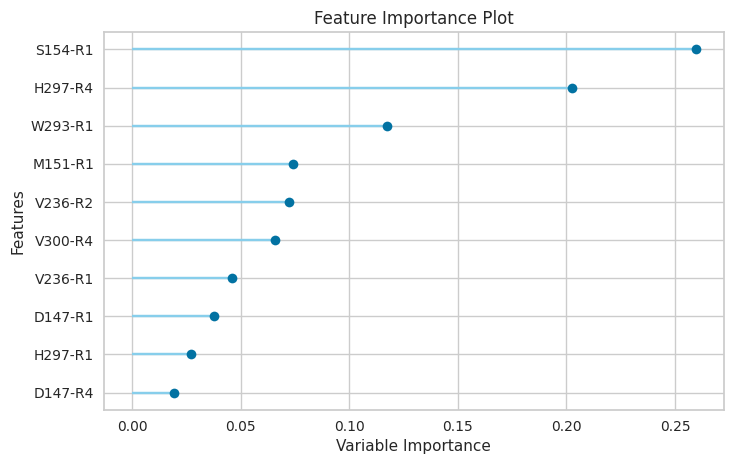

In [12]:
pred_results = feat_3('rf', 100)
features = [item for sublist in pred_results['feat'].tolist() for item in sublist]

# Plot important features by rank (averaged over the 100 trials)

In [14]:
from collections import defaultdict
import numpy as np
features = [(i, j) for i,j in zip(pred_results['feat'], pred_results['Impt'])]
features = [dict(zip(f[0], f[1])) for f in features]
features_all = defaultdict(list)
for f in features:
    for key,value in f.items():
        features_all[key].append(value)

features_avg = {}
for k,v in features_all.items():
    features_avg[k] = (np.mean(v), np.std(v))
        
features_avg =  {k:v for k, v in sorted(features_avg.items(), key=lambda item: item[1][0], reverse=True)}

In [15]:
r2 = []
x = []
y = []
err = []
for k,v in features_avg.items():
    x.append(k)
    y.append(v[0])
    err.append(v[1])
    r2.append(np.sqrt(cal_r2(data['rt'], data[k])))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


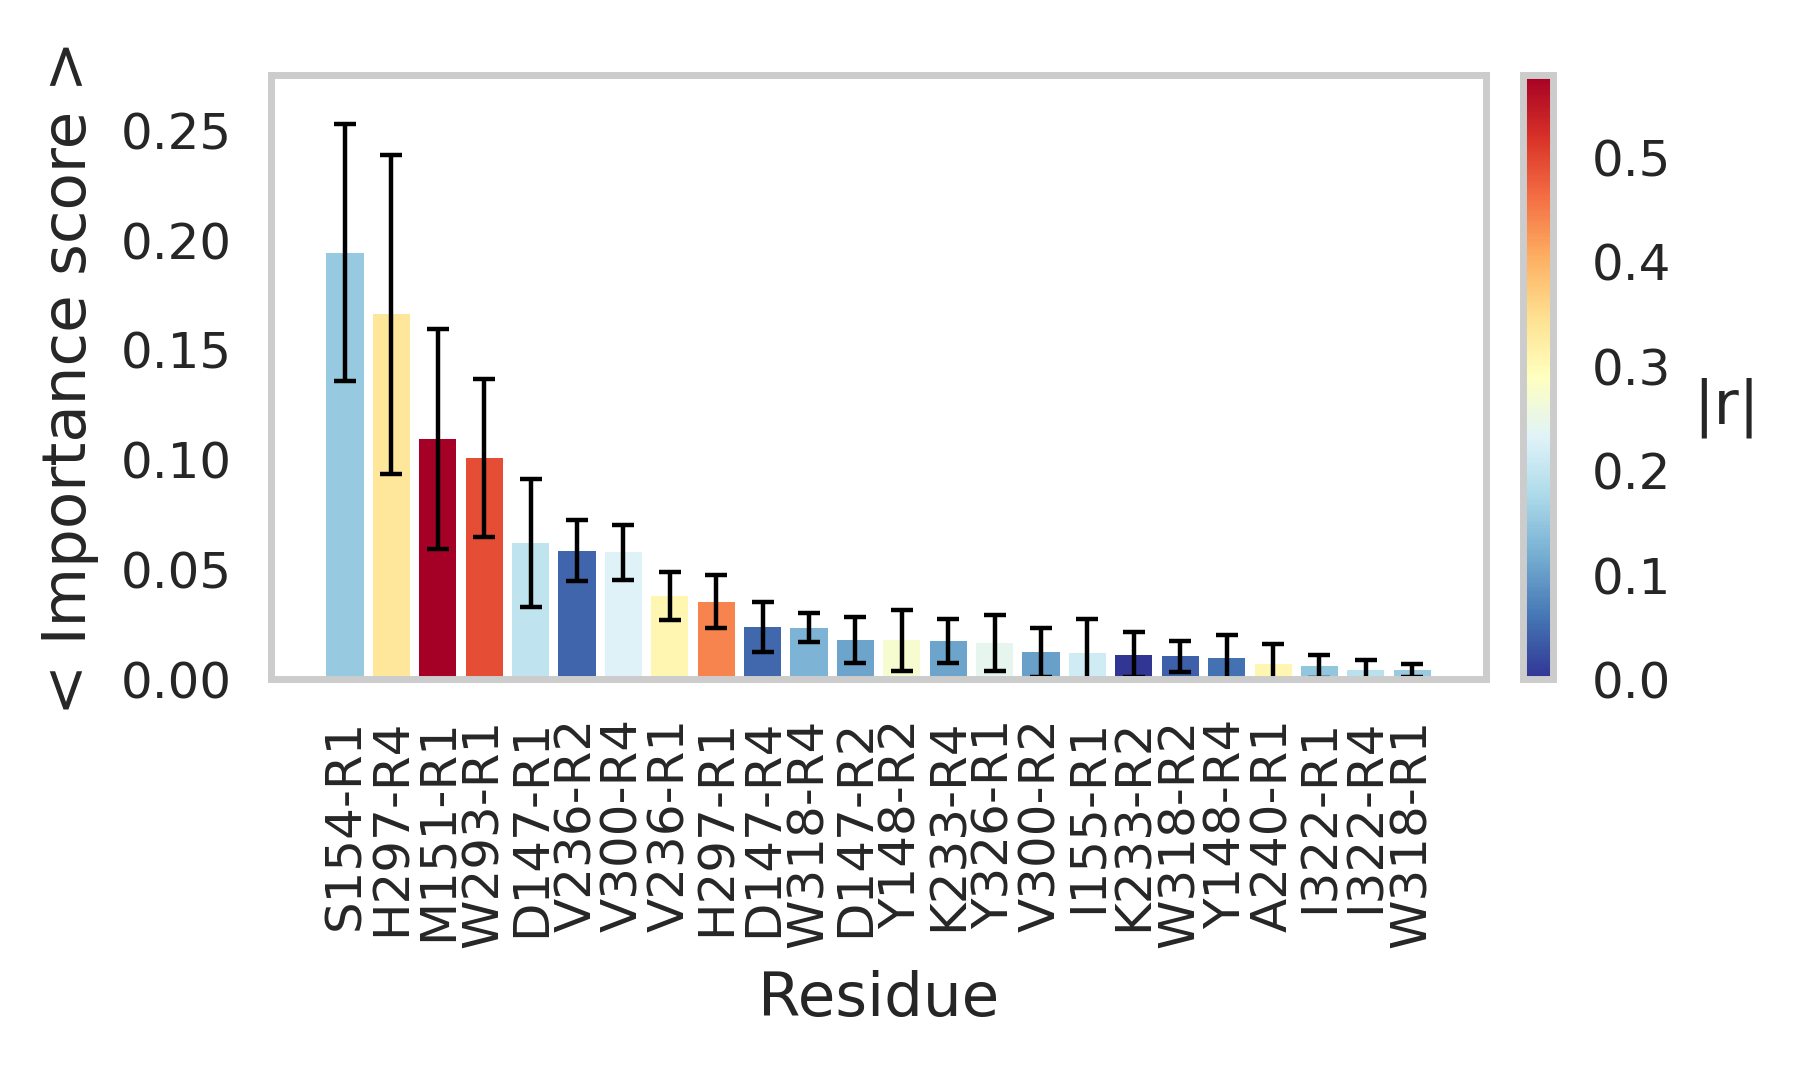

In [16]:
from matplotlib.cm import ScalarMappable

cm = plt.cm.get_cmap('RdYlBu_r')
r2_span = max(r2) - min(r2)
C = [cm(((i-min(r2))/r2_span)) for i in r2]
fig, ax = plt.subplots(figsize=(4.75,2.0), dpi=400)
error_kw = dict(lw=0.8, capsize=2, capthick=0.8) # {'markeredgewidth':2}
b = ax.bar(range(len(y)), y, color=C, yerr=err, ecolor='black', capsize=3, error_kw=error_kw)
# ax.errorbar(range(len(y)), y, yerr=err, color='black', fmt='.')
plt.ylim(0,0.275)
ax.set_xlabel('Residue')
ax.set_ylabel(r'< Importance score >',fontsize=11)
xticks = [i for i in range(len(y))]
xtick_labels = x

ax.set_xticks(xticks, xtick_labels,rotation=90)
ax.tick_params(axis='both', labelsize=9)
sm = ScalarMappable(cmap=cm, norm=plt.Normalize(0, max(r2)))
sm.set_array([])
ax.yaxis.grid(False)
ax.xaxis.grid(False)
cbar = plt.colorbar(sm,pad=0.025)
cbar.ax.tick_params(labelsize=9)
cbar.set_label(r'|r|',rotation=0,labelpad=10)

# SHAP plot

In [17]:
s = setup(data, ignore_features=['Lig'], target = 'rt', silent=True, fold=10, verbose=False,
              train_size=0.8, n_jobs=6, remove_multicollinearity=False, 
              data_split_stratify=True, use_gpu=False, feature_selection=True)
est = tune_model(create_model('rf', verbose=False,), verbose=False, choose_better = True, 
                 return_train_score=True, optimize='MSE')


In [21]:
explainer = shap.TreeExplainer(est)
S = s[36]

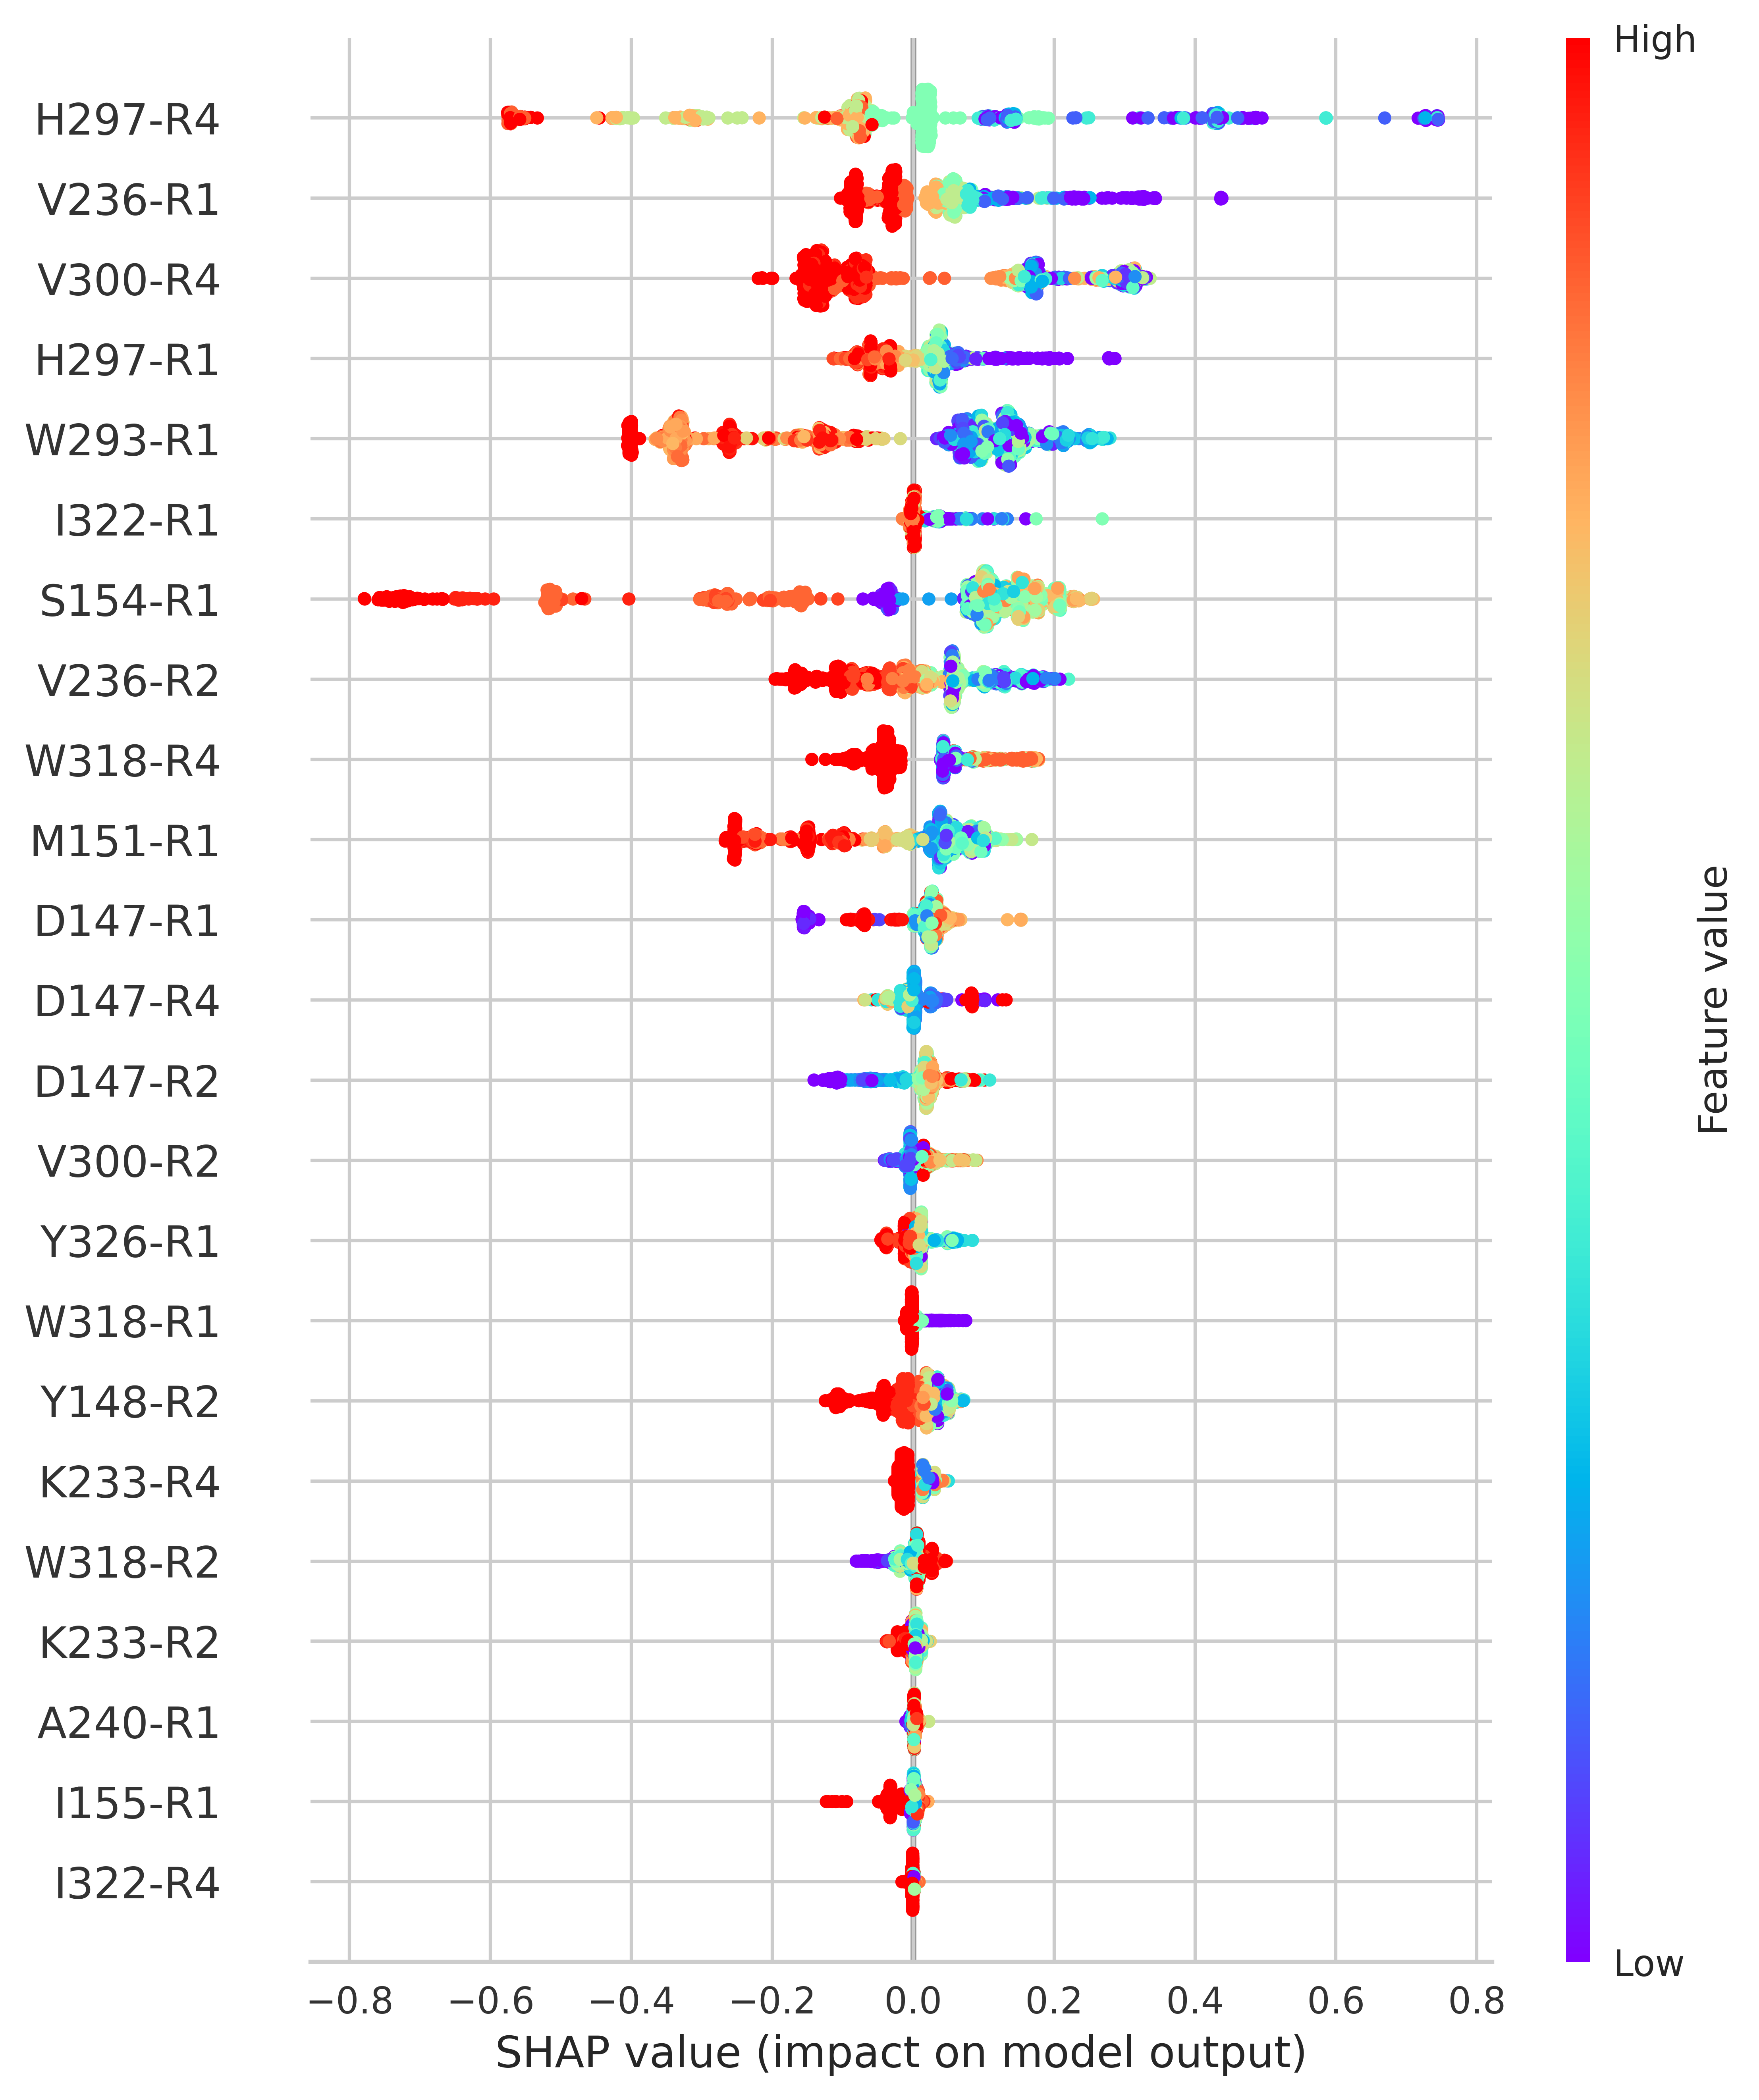

In [24]:
shap_values = explainer.shap_values(S)
shap_obj = explainer(S)

fig, ax = plt.subplots(figsize=(5,4.5), dpi=600)
shap.plots.beeswarm(shap_obj,order=shap.Explanation.max(0),max_display=24,show=True,color_bar=True,
                    color=plt.get_cmap("rainbow"))
